Import the libraries needed

In [1]:
import pandas as pd
import numpy as np
import os
import pyodbc
pyodbc.drivers()
from datetime import datetime
import psutil

# For the Yahoo Finance api
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')

C:\Users\m033\Anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
pd.set_option('max_row', None)
#pd.options.display.max_rows = 1000

# Set a value for the home folder.
home_folder = "."

# Set values for the various paths.
input_path = home_folder + "\data"

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-07-19 18:43:54.049913
svmem(total=16756752384, available=4232650752, percent=74.7, used=12524101632, free=4232650752)


### All the data used has been provisined in Get_The_Data.ipynb

# Investigated the spike and it is downw to a fund closure on those dates.

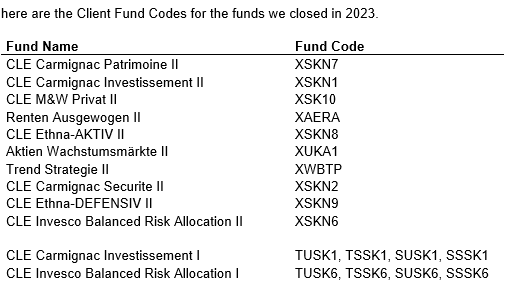

# 1. Read back the dataset of all switches.

In [3]:
# giving directory name
All_Switches = input_path + '\All_Switches.csv'

df_All_Switches = pd.read_csv(All_Switches, delimiter=',',low_memory=False, header=0)

# Filter out old dates.
df_All_Switches = df_All_Switches[df_All_Switches.PROCESSING_DATE > '20181231']

# Make the processing date a real date.
df_All_Switches['PROCESSING_DATE'] = pd.to_datetime(df_All_Switches['PROCESSING_DATE'])

# print stats.
print(len(df_All_Switches.index))
print(df_All_Switches.dtypes)
df_All_Switches.head(5)

201805
index                              int64
POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
dtype: object


,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
0,0,6535239K,XMLEM,GNRP_2012V1,2019-01-02,2018-12-28,A,B,2763.7400,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P
1,1,6535239K,XSK10,GNRP_2012V1,2019-01-02,2018-12-28,A,B,-5527.4800,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P
2,2,6535239K,XSKN3,GNRP_2012V1,2019-01-02,2018-12-28,A,B,2763.7400,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P
3,3,6562520M,XSDIV,GNRP_2012V1,2019-01-02,2018-12-27,A,B,10864.3901,2014-12-25,A947,2014-12-30,1900-01-01,1900-01-01,NaN,P
4,4,6562520M,XSEDD,GNRP_2012V1,2019-01-02,2018-12-27,A,B,-10864.3901,2014-12-25,A947,2014-12-30,1900-01-01,1900-01-01,NaN,P


# 2. Create a new dataframe with switches for the fund close date range.

In [4]:
from_dt = '2022-04-01'
to_dt   = '2022-07-31'
df_Fund_Close_Period = df_All_Switches[(df_All_Switches['PROCESSING_DATE'] > from_dt) & (df_All_Switches['PROCESSING_DATE'] < to_dt)]

print(len(df_Fund_Close_Period.index))
df_Fund_Close_Period.head(5)

9893


,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
91377,90267,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91378,90268,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91379,90269,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91380,90270,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91381,90271,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P


# 3. Get a list of policies that were involved in a fund closure.

In [5]:
# These are the funds that were closed.
close_funds = ['XSKN7','XSKN1','XSK10','XAERA','XSKN8','XUKA1','XWBTP','XSKN2','XSKN9',
               'XSKN6','TUSK1','TSSK1','SUSK1','SSSK1','TUSK6','TSSK6','SUSK6','SSSK6']

print('These are the funds that were closed.',close_funds)

# Find the rows where this exists
df_Fund_Close_Pols = df_Fund_Close_Period[df_Fund_Close_Period.LEGACY_FUND_CODE.isin(close_funds)]


# Find the rows where this exists
#df_Fund_Close_Pols = df_Fund_Close_Period[~df_Fund_Close_Period.LEGACY_FUND_CODE.isin(close_funds)]
df_Fund_Close_Pols = df_Fund_Close_Period[df_Fund_Close_Period.LEGACY_FUND_CODE.isin(close_funds)]

# Isolate teh policy number
df_Fund_Close_Unique_Pols = df_Fund_Close_Pols[['POLICY_NUMBER']]

# Drop duplicate policy numbers
df_Fund_Close_Unique_Pols = df_Fund_Close_Unique_Pols.drop_duplicates(subset=['POLICY_NUMBER'], keep='first')

df_Fund_Close_Unique_Pols = df_Fund_Close_Unique_Pols.rename(columns={"POLICY_NUMBER":"Pols_To_Delete"})
df_Fund_Close_Unique_Pols.head(5)

# Write out to a comma separated values file.
filename = input_path + '\Fund_Close_Unique_Pols.csv'
df_Fund_Close_Unique_Pols.to_csv(filename, encoding='utf-8', index=False)  

print(len(df_Fund_Close_Unique_Pols.index))
print(filename)
df_Fund_Close_Unique_Pols.head(5)

These are the funds that were closed. ['XSKN7', 'XSKN1', 'XSK10', 'XAERA', 'XSKN8', 'XUKA1', 'XWBTP', 'XSKN2', 'XSKN9', 'XSKN6', 'TUSK1', 'TSSK1', 'SUSK1', 'SSSK1', 'TUSK6', 'TSSK6', 'SUSK6', 'SSSK6']
69
.\data\Fund_Close_Unique_Pols.csv


,Pols_To_Delete
91772,8092278M
91780,8111065D
91995,6279391K
92080,6792420L
92128,6098033F


# 4. Using the policy numbers from the list of policies that were involved in a fund closure, create a list of switches to delete.

In [6]:
print(len(df_Fund_Close_Period.index))
print(len(df_Fund_Close_Unique_Pols.index))


9893
69


In [7]:
df_LEFT_A = pd.merge(df_Fund_Close_Period, df_Fund_Close_Unique_Pols, left_on = ['POLICY_NUMBER'], right_on = ['Pols_To_Delete'] , how = 'left') 
print(len(df_LEFT_A.index))

# Write out to a comma separated values file.
filename = input_path + '\df_LEFT_A.csv'
df_LEFT_A.to_csv(filename, encoding='utf-8', index=False)  

print(filename)
df_LEFT_A.head(25)

9893
.\data\df_LEFT_A.csv


,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE,Pols_To_Delete
0,90267,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
1,90268,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
2,90269,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
3,90270,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
4,90271,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
5,90272,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8259,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
6,90273,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,81.7275,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
7,90274,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,70.0948,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
8,90275,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8254,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
9,90276,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,-6052.3904,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN


In [8]:
print(len(df_Fund_Close_Period.index))
print(len(df_Fund_Close_Unique_Pols.index))
print(len(df_LEFT_A.index))

9893
69
9893


# 5. Delete the fund closure switches.

In [9]:
df_LEFT_A.head(10)

,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE,Pols_To_Delete
0,90267,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
1,90268,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
2,90269,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
3,90270,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
4,90271,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
5,90272,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8259,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
6,90273,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,81.7275,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
7,90274,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,70.0948,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
8,90275,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8254,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
9,90276,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,-6052.3904,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN


In [10]:
# nOW DELETE ALL ROWS WHERE Pols_To_Delete is not NULL
print(len(df_LEFT_A.index))

9893


In [11]:
#df = df_LEFT_A[df_LEFT_A.Pols_To_Delete != 'NaN']
df_LEFT_A = df_LEFT_A[df_LEFT_A.Pols_To_Delete.isnull()]
print(len(df_LEFT_A.index))


6978


In [12]:
df_Closed_Funds_Policies_Removed = df_LEFT_A.drop(['index','Pols_To_Delete'],axis=1)
print(len(df_Closed_Funds_Policies_Removed.index))
print(len(df_LEFT_A.index))

6978
6978


In [13]:
#df = df_LEFT_A[df_LEFT_A.Pols_To_Delete != 'NaN']
#df_Closed_Funds_Policies_Removed = df_LEFT_A[df_LEFT_A.Pols_To_Delete.isnull()]
print(len(df_Closed_Funds_Policies_Removed.index))
print(len(df_LEFT_A.index))

6978
6978


In [14]:
df_Closed_Funds_Policies_Removed.head(10)

,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
0,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
1,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
2,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
3,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
4,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
5,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8259,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
6,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,81.7275,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
7,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,70.0948,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
8,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8254,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
9,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,-6052.3904,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P


In [15]:
# Write out to a comma separated values file.
filename = input_path + '\Closed_Funds_Policies_Removed.csv'
df_Closed_Funds_Policies_Removed.to_csv(filename, encoding='utf-8', index=False)  

print(len(df_Closed_Funds_Policies_Removed.index))
print(len(df_Fund_Close_Period.index))

print(filename)
df_Closed_Funds_Policies_Removed.head(25)

6978
9893
.\data\Closed_Funds_Policies_Removed.csv


,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
0,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
1,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
2,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
3,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
4,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
5,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8259,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
6,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,81.7275,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
7,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,70.0948,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
8,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,95.8254,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
9,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,-6052.3904,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P


# 6. Create a dataframe with all other dates, outside teh fund closure period.

In [16]:
# Create a dataframe with all other dates.
from_dt = '2022-04-01'
to_dt = '2022-07-31'
df_Fund_NON_Close_Period = df_All_Switches[(df_All_Switches['PROCESSING_DATE'] < from_dt) | (df_All_Switches['PROCESSING_DATE'] > to_dt)]


# Write out to a comma separated values file.
filename = input_path + '\Fund_NON_Close_Period.csv'
df_Fund_NON_Close_Period.to_csv(filename, encoding='utf-8', index=False)  

print(len(df_Fund_NON_Close_Period.index))

print(filename)
df_Fund_NON_Close_Period.head(5)

191863
.\data\Fund_NON_Close_Period.csv


,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
0,0,6535239K,XMLEM,GNRP_2012V1,2019-01-02,2018-12-28,A,B,2763.7400,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P
1,1,6535239K,XSK10,GNRP_2012V1,2019-01-02,2018-12-28,A,B,-5527.4800,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P
2,2,6535239K,XSKN3,GNRP_2012V1,2019-01-02,2018-12-28,A,B,2763.7400,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P
3,3,6562520M,XSDIV,GNRP_2012V1,2019-01-02,2018-12-27,A,B,10864.3901,2014-12-25,A947,2014-12-30,1900-01-01,1900-01-01,NaN,P
4,4,6562520M,XSEDD,GNRP_2012V1,2019-01-02,2018-12-27,A,B,-10864.3901,2014-12-25,A947,2014-12-30,1900-01-01,1900-01-01,NaN,P


# 7. Merge them back to get a dataframe that has the full set of switches, MINUS switches for policies involved in the fund closure.

In [17]:
# Merge the dataframes.
df_All_Switches_Without_Fund_Close= df_Closed_Funds_Policies_Removed.append(df_Fund_NON_Close_Period)
#df_Switches_Without_Fund_Close = df_Switches_Without_Fund_Close.drop(['Pols_To_Delete','level_0','index'],axis=1)

df_All_Switches_Without_Fund_Close.head(5)

,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE,index
0,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
1,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
2,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
3,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN
4,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P,NaN


In [18]:
print("df_Fund_Close_Period             :",len(df_Fund_Close_Period.index))
print('df_Closed_Funds_Policies_Removed :',len(df_Closed_Funds_Policies_Removed.index))
print('df_Fund_NON_Close_Period         :',len(df_Fund_NON_Close_Period.index))
print('df_All_Switches                  :',len(df_All_Switches.index))


df_Fund_Close_Period             : 9893
df_Closed_Funds_Policies_Removed : 6978
df_Fund_NON_Close_Period         : 191863
df_All_Switches                  : 201805


In [19]:
df_All_Switches_Without_Fund_Close.dtypes

POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
index                            float64
dtype: object

# 8. Re-sort by policy number and processing date and write out file.

In [20]:
# Soryt by policy number and processing date.
#df_All_Switches_Without_Fund_Close = df_All_Switches_Without_Fund_Close.sort_values(['PROCESSING_DATE','POLICY_NUMBER','SOURCE']).reset_index(drop=False)
df_All_Switches_Without_Fund_Close = df_All_Switches_Without_Fund_Close.sort_values(['PROCESSING_DATE','POLICY_NUMBER','SOURCE'])

print(len(df_All_Switches_Without_Fund_Close.index))

# Write out to a comma separated values file.
filename = input_path + '\All_Switches_Without_Fund_Close.csv'
df_All_Switches_Without_Fund_Close.to_csv(filename, encoding='utf-8', index=False)      

print(filename)
df_All_Switches_Without_Fund_Close.head(10)

198841


C:\Users\m033\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:2106: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


.\data\All_Switches_Without_Fund_Close.csv


,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE,index
0,6535239K,XMLEM,GNRP_2012V1,2019-01-02,2018-12-28,A,B,2763.7400,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P,0.0
1,6535239K,XSK10,GNRP_2012V1,2019-01-02,2018-12-28,A,B,-5527.4800,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P,1.0
2,6535239K,XSKN3,GNRP_2012V1,2019-01-02,2018-12-28,A,B,2763.7400,2013-12-19,A28E,2013-12-19,1900-01-01,1900-01-01,NaN,P,2.0
3,6562520M,XSDIV,GNRP_2012V1,2019-01-02,2018-12-27,A,B,10864.3901,2014-12-25,A947,2014-12-30,1900-01-01,1900-01-01,NaN,P,3.0
4,6562520M,XSEDD,GNRP_2012V1,2019-01-02,2018-12-27,A,B,-10864.3901,2014-12-25,A947,2014-12-30,1900-01-01,1900-01-01,NaN,P,4.0
5,6651310C,BUWP6,GNPP_2016V1,2019-01-02,2018-12-31,A,B,-221.3397,2017-01-01,A8D7,2016-12-28,1900-01-01,1900-01-01,NaN,P,5.0
6,6651310C,RUWP6,GNPP_2016V1,2019-01-02,2018-12-31,A,B,-231.0452,2017-01-01,A8D7,2016-12-28,1900-01-01,1900-01-01,NaN,P,6.0
7,6651310C,XUEAA,GNPP_2016V1,2019-01-02,2018-12-31,A,B,-212.5059,2017-01-01,A8D7,2016-12-28,1900-01-01,1900-01-01,NaN,P,7.0
8,6651310C,XUEAA,GNPP_2016V1,2019-01-02,2018-12-31,A,B,433.2002,2017-01-01,A8D7,2016-12-28,1900-01-01,1900-01-01,NaN,P,8.0
9,6128381Y,SUEAM,XRP_2003V2,2019-01-03,2019-01-02,A,B,-327.4962,2004-11-01,E396,2004-10-22,1900-01-01,1900-01-01,NaN,P,9.0


# 9. Get the switchable funds/switch counts.

In [21]:
filename = input_path + '\Full_Population_Count.csv'
df_Full_Population_Count = pd.read_csv(filename, delimiter=',',low_memory=False, header=0)
print(len(df_Full_Population_Count.index))

print(filename)
df_Full_Population_Count.head(5)

66
.\data\Full_Population_Count.csv


,SnapshotYrMth,counts
0,201901,62801
1,201902,63720
2,201903,64775
3,201904,65713
4,201905,66774


# 10. Create the Fund Switch Count dataframe.

In [22]:
df_All_Switches_Without_Fund_Close.dtypes

POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
index                            float64
dtype: object

In [23]:
df_Switches_Count = df_All_Switches_Without_Fund_Close[['POLICY_NUMBER','PROCESSING_DATE']]
#df_All_Switches['PROCESSING_DATE'] = pd.to_datetime(df_All_Switches['PROCESSING_DATE'].str.strip(), format='%Y/%m/%d')
df_Switches_Count['ProcessingtDt'] = df_Switches_Count['PROCESSING_DATE'].dt.strftime('%Y%m')

# Drop obsolete columns.
#df_Switches_Count = df_All_Switches.drop(['LEGACY_FUND_CODE','PRODUCT','EFFECTIVE_DATE','UNIT_TYPE',
#                                          'CHARGE_TYPE','CASH_VALUE','RISK_COMMENCEMENT_DATE','Cover_End_Date',
#                                         'index','Servicing_Broker_Code','Issue_Date','Anniversary_Date','SOURCE',
#                                          'PROCESSING_DATE','level_0','Pols_To_Delete'],axis=1)

# Stats
print(len(df_Switches_Count.index))
df_Switches_Count.head(5)

198841


C:\Users\m033\AppData\Local\Temp\ipykernel_14152\3710847059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Switches_Count['ProcessingtDt'] = df_Switches_Count['PROCESSING_DATE'].dt.strftime('%Y%m')


,POLICY_NUMBER,PROCESSING_DATE,ProcessingtDt
0,6535239K,2019-01-02,201901
1,6535239K,2019-01-02,201901
2,6535239K,2019-01-02,201901
3,6562520M,2019-01-02,201901
4,6562520M,2019-01-02,201901


In [24]:
df_Switches_Count.tail(25)

,POLICY_NUMBER,PROCESSING_DATE,ProcessingtDt
201780,6246612A,2024-07-17,202407
201781,6246612A,2024-07-17,202407
201782,6246612A,2024-07-17,202407
201783,6246612A,2024-07-17,202407
201784,6246612A,2024-07-17,202407
201785,6246612A,2024-07-17,202407
201786,6246612A,2024-07-17,202407
201787,6246612A,2024-07-17,202407
201788,6246612A,2024-07-17,202407
201789,6246612A,2024-07-17,202407


# 11. Drop duplicate policy numbers

In [25]:
# Drop duplicate policy numbers
df_Switches_Count = df_Switches_Count.drop_duplicates(subset=['POLICY_NUMBER','ProcessingtDt'], keep='first')
df_Switches_Count = df_Switches_Count.drop(['POLICY_NUMBER'],axis=1)

# print stats.
print(len(df_Switches_Count.index))
df_Switches_Count.head(5)

7738


,PROCESSING_DATE,ProcessingtDt
0,2019-01-02,201901
3,2019-01-02,201901
5,2019-01-02,201901
9,2019-01-03,201901
144,2019-01-07,201901


In [26]:
# Reset teh index on count
df_Switches_Count=df_Switches_Count[['ProcessingtDt']].value_counts().reset_index(name='counts')

# Sort by ProcessingtDt
df_Switches_Count = df_Switches_Count.sort_values(by=['ProcessingtDt'])

print(len(df_Switches_Count.index))
df_Switches_Count.head(5)

67


,ProcessingtDt,counts
29,201901,75
63,201902,32
19,201903,91
47,201904,50
50,201905,48


In [27]:
df_Switches_Count.tail(25)

,ProcessingtDt,counts
46,202207,53
44,202208,56
41,202209,61
59,202210,42
40,202211,62
32,202212,70
51,202301,48
33,202302,69
15,202303,96
2,202304,364


In [29]:
df_All_Switches_Without_Fund_Close.dtypes

POLICY_NUMBER                     object
LEGACY_FUND_CODE                  object
PRODUCT                           object
PROCESSING_DATE           datetime64[ns]
EFFECTIVE_DATE                    object
UNIT_TYPE                         object
CHARGE_TYPE                       object
CASH_VALUE                       float64
RISK_COMMENCEMENT_DATE            object
Servicing_Broker_Code             object
Issue_Date                        object
Cover_End_Date                    object
Anniversary_Date                  object
Source                            object
SOURCE                            object
index                            float64
dtype: object

## Create the Fund Switch Count dataframe.

In [30]:
df_All_Switches = df_All_Switches_Without_Fund_Close
#df_All_Switches['PROCESSING_DATE'] = pd.to_datetime(df_All_Switches['PROCESSING_DATE'].str.strip(), format='%Y/%m/%d')
df_All_Switches['ProcessingtDt'] = df_All_Switches['PROCESSING_DATE'].dt.strftime('%Y%m')

# Drop obsolete columns.
df_Switches_Count = df_All_Switches.drop(['POLICY_NUMBER','LEGACY_FUND_CODE','PRODUCT','EFFECTIVE_DATE','UNIT_TYPE',
                                          'CHARGE_TYPE','CASH_VALUE','RISK_COMMENCEMENT_DATE','Cover_End_Date',
                                         'index','Servicing_Broker_Code','Issue_Date','Anniversary_Date','SOURCE','PROCESSING_DATE'],axis=1)

# Reset teh index on count
df_Switches_Count=df_Switches_Count[['ProcessingtDt']].value_counts().reset_index(name='counts')

# Sort by ProcessingtDt
df_Switches_Count = df_Switches_Count.sort_values(by=['ProcessingtDt'])

print(len(df_Switches_Count.index))
df_Switches_Count.head(5)

67


,ProcessingtDt,counts
28,201901,1841
56,201902,1040
20,201903,2463
50,201904,1170
40,201905,1497


In [31]:
df_Switches_Count.tail(55)

,ProcessingtDt,counts
17,202001,2803
31,202002,1765
8,202003,4621
23,202004,2089
44,202005,1271
58,202006,1029
61,202007,938
57,202008,1038
47,202009,1217
34,202010,1670


In [32]:
df_Full_Population_Count.head(5)

,SnapshotYrMth,counts
0,201901,62801
1,201902,63720
2,201903,64775
3,201904,65713
4,201905,66774


## Now remove all instances of these policies in the close fund period.

In [43]:
print(len(df_Fund_Close_Period.index))
print(df_Fund_Close_Period.head(5))
print(df_Fund_Close_Period.tail(5))


# Write out to a comma separated values file.
filename = input_path + '\Fund_Close_Period.csv'
df_Fund_Close_Period.to_csv(filename, encoding='utf-8', index=False)  

print(filename)

9893
       index POLICY_NUMBER LEGACY_FUND_CODE     PRODUCT PROCESSING_DATE  \
91377  90267      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91378  90268      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91379  90269      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91380  90270      6141188W            SUDGB  XRP_2003V2      2022-04-04   
91381  90271      6141188W            SUDGB  XRP_2003V2      2022-04-04   

      EFFECTIVE_DATE UNIT_TYPE CHARGE_TYPE  CASH_VALUE RISK_COMMENCEMENT_DATE  \
91377     2022-03-31         A           B   6052.3908             2004-12-01   
91378     2022-03-31         A           B    175.2501             2004-12-01   
91379     2022-03-31         A           B    157.6735             2004-12-01   
91380     2022-03-31         A           B    142.0594             2004-12-01   
91381     2022-03-31         A           B    125.2194             2004-12-01   

      Servicing_Broker_Code  Issue_Date Cover_End_Date An

In [44]:
print(len(df_Fund_Close_Unique_Pols.index))
df_Fund_Close_Unique_Pols.head(5)

69


,Pols_To_Delete
91772,8092278M
91780,8111065D
91995,6279391K
92080,6792420L
92128,6098033F


## Remove close fund pols from teh full list from that period.

In [45]:
close_fund_pols = df_Fund_Close_Unique_Pols.values.tolist()

# Stata
close_fund_pols

[['8092278M'],
 ['8111065D'],
 ['6279391K'],
 ['6792420L'],
 ['6098033F'],
 ['8022139O'],
 ['8111897K'],
 ['6127410#'],
 ['6718817C'],
 ['8019998L'],
 ['8057346W'],
 ['8086902C'],
 ['6138178A'],
 ['6324584P'],
 ['6552163F'],
 ['6560215A'],
 ['8105537Z'],
 ['6522074K'],
 ['6303999W'],
 ['6502024K'],
 ['6508872K'],
 ['6496649M'],
 ['6760861A'],
 ['6316340P'],
 ['6598071M'],
 ['6793023F'],
 ['6535965W'],
 ['6168372A'],
 ['6168434Y'],
 ['6134779P'],
 ['6533269K'],
 ['6536640Y'],
 ['6567064W'],
 ['6333815E'],
 ['6520054L'],
 ['6551528L'],
 ['6322325F'],
 ['6333808F'],
 ['6704387K'],
 ['6704421F'],
 ['6254184E'],
 ['6483884K'],
 ['6511099K'],
 ['6640440F'],
 ['6406453K'],
 ['6704519F'],
 ['6705398A'],
 ['6356358W'],
 ['6428250Y'],
 ['6698760Y'],
 ['6804076E'],
 ['6577814C'],
 ['6432649F'],
 ['6046588M'],
 ['6392875F'],
 ['6666774F'],
 ['6666784K'],
 ['6283271L'],
 ['6725381F'],
 ['8058227V'],
 ['6521305H'],
 ['6396479Y'],
 ['6520669Y'],
 ['6667161H'],
 ['6294512P'],
 ['6588593Y'],
 ['6544200

In [46]:
df_Fund_Close_Period.head(5)

,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
91377,90267,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91378,90268,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91379,90269,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91380,90270,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91381,90271,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P


In [47]:
df_Fund_Close_Period_New = df_Fund_Close_Period[df_Fund_Close_Period.POLICY_NUMBER.isin(close_fund_pols)]

print(len(df_Fund_Close_Period_New.index))
df_Fund_Close_Period_New.head(5)

0


,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE


In [48]:
print(len(df_Fund_Close_Period.index))
df_Fund_Close_Period.head(5)

9893


,index,POLICY_NUMBER,LEGACY_FUND_CODE,PRODUCT,PROCESSING_DATE,EFFECTIVE_DATE,UNIT_TYPE,CHARGE_TYPE,CASH_VALUE,RISK_COMMENCEMENT_DATE,Servicing_Broker_Code,Issue_Date,Cover_End_Date,Anniversary_Date,Source,SOURCE
91377,90267,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,6052.3908,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91378,90268,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,175.2501,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91379,90269,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,157.6735,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91380,90270,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,142.0594,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P
91381,90271,6141188W,SUDGB,XRP_2003V2,2022-04-04,2022-03-31,A,B,125.2194,2004-12-01,5784,2004-11-18,1900-01-01,1900-01-01,NaN,P


In [49]:
%who_ls DataFrame 

['df_All_Switches',
 'df_All_Switches_Without_Fund_Close',
 'df_Closed_Funds_Policies_Removed',
 'df_Full_Population_Count',
 'df_Fund_Close_Period',
 'df_Fund_Close_Period_New',
 'df_Fund_Close_Pols',
 'df_Fund_Close_Unique_Pols',
 'df_Fund_NON_Close_Period',
 'df_LEFT_A',
 'df_Switches_Count']

In [51]:
del df_All_Switches
del df_All_Switches_Without_Fund_Close
del df_Closed_Funds_Policies_Removed
del df_Full_Population_Count
del df_Fund_Close_Period
del df_Fund_Close_Period_New
del df_Fund_Close_Pols
del df_Fund_Close_Unique_Pols
del df_Fund_NON_Close_Period
del df_LEFT_A
del df_Switches_Count

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-07-19 18:48:16.550210
svmem(total=16756752384, available=5439119360, percent=67.5, used=11317633024, free=5439119360)
